## Quantum Probabilisitc Modelling

Quantum computers can be used to calculate joint probability distributions of correlated probabilsistc parameters due to the probabilistic nature. Here we show the idea of how these models can be used for risk modelling.

One example is modelling business risks. An important question for any business is: 
What would be the impact of external adverse developments on future revenues? For example, these developments could be caused by (macro-)economic, or political events, by competition, or changes in the company’s reputation, or regulation or tax, etc. A major problem for the analysis of this kind of environmental circumstances is that these factors not only (potentially) influence revenues, but are also interlinked in many cases, i.e. they influence each other.


(for further information about business risk see https://arxiv.org/abs/2103.05475)

In [1]:
# import pygrnd and other libraries needed
# we build on top of the open source framework qiskit (qiskit.org)
import pygrnd

from pygrnd.qc.helper import *
from pygrnd.qc.brm import *
from pygrnd.qc.brm_oracle import *
from pygrnd.qc.QAE import *

from qiskit import execute
from qiskit import Aer

from math import pi
import math
import cmath
import random
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from scipy.stats import norm
import networkx as nx
from IPython.display import Image

## 1. Define the model

- the model is a Graphical Probabilistic Model (GPM), which is a graph with nodes and edges

- in its easiest form it is a binary decision tree, equivalent to a directed graph (only one direction) where each node has only one incoming node

- extensions allow several edges into one node

- risk parameter: nodes=['0','1']
- list of correlations: edges=[('0','1')]
- probabilities that an item gets triggered: probsNodes={'0':0.1,'1':0.1}
- probabilities for transition: probsEdges={('0','1'):0.2}

In [2]:
## small example

nodes=['0','1'] # risk items defition
edges=[('0','1')] # correlations

probsNodes={'0':0.1,'1':0.1} # intrinsic probs
probsEdges={('0','1'):0.2} # transition probs

print("Number of risk items = ",len(nodes))
print("Number of correlations = ",len(edges))


Number of risk items =  2
Number of correlations =  1


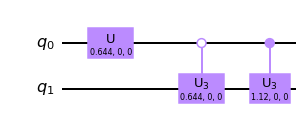

In [3]:
rm, mat = brm(nodes, edges, probsNodes, probsEdges, model2gate=False) 
rm.draw(output='mpl')

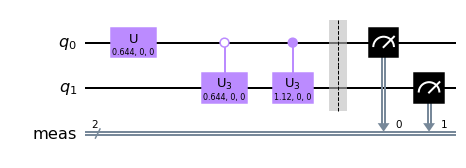

-------------------------------


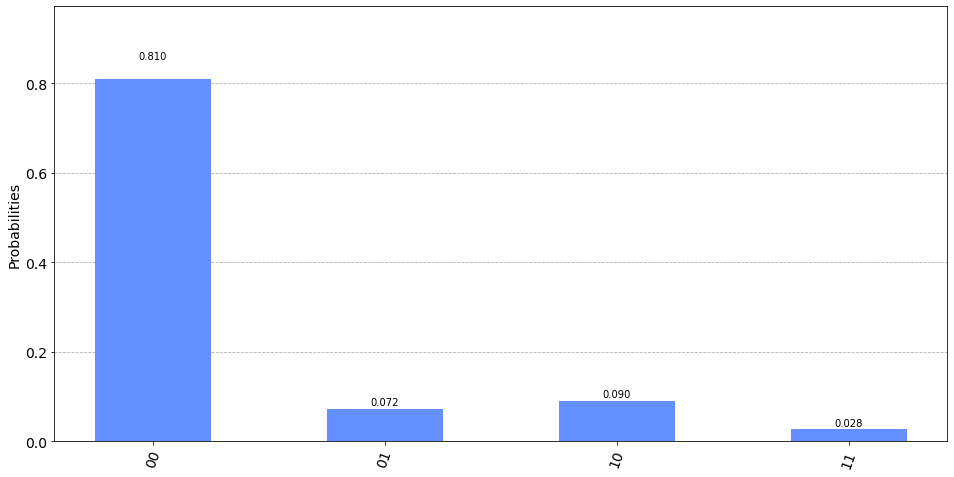

In [4]:

# execute function to build a qiskit gate with the risk model
#rm, mat = brm(nodes, edges, probsNodes, probsEdges, model2gate=False) 

rm.measure_all()
display(rm.draw(output='mpl'))
print("-------------------------------")

backend = Aer.get_backend('qasm_simulator')
job = execute(rm, backend,shots=100000)
result=job.result()
counts=job.result().get_counts()
plot_histogram(counts,figsize=(16,8))

In [5]:
## evaluate classically
modelProbabilities(nodes,edges,probsNodes,probsEdges)

([0.81, 0.08999999999999998, 0.072, 0.027999999999999987], 1.0)

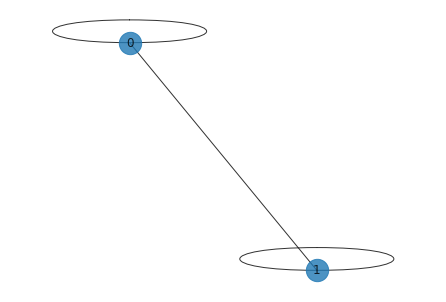

In [6]:
## building the graph from adjacency matrix for visual representation
G = nx.Graph()
G = nx.from_numpy_array(mat)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [7]:
## use Oracle to build QAE and evaluate probabaility for state 'STATELIST'
name="test"
STATELIST=["11"] # we search for the joint probability where both parameters are triggered
Nshots=1000 # number of shots
QAEqubits=4 # QAE bit precision --> 8 bit strings at the end of the measurement to differentiate 2^8 = 265 bins


#rm = BRMlist(RIlist,TPlist,model2gate=True)
rm, mat = brm(nodes, edges, probsNodes, probsEdges, model2gate=True) 
ora = brmoracle("ora",rm,len(nodes),0,STATELIST)
QAE=qae(QAEqubits,len(nodes),len(nodes),rm,ora)

In [8]:
## execution with local quantum simulator (qasm simulator)

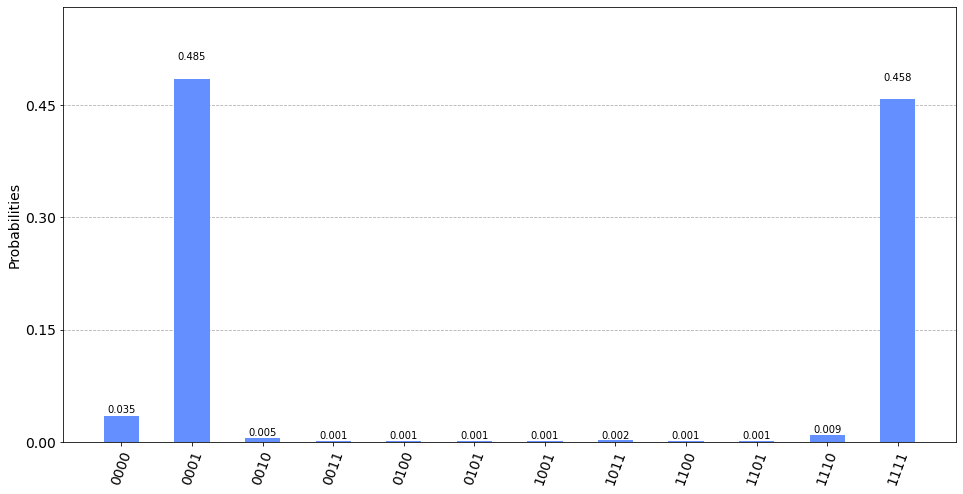

In [9]:
backend = Aer.get_backend('qasm_simulator')
job = execute(QAE, backend,shots=Nshots)
result=job.result()
counts=job.result().get_counts()
plot_histogram(counts,figsize=(16,8))

In [10]:
# post processing: we see two different peaks from the QAE

showQAEoutput(counts,STATELIST,QAEqubits)

Bin with the highest probability:  0001
Number of Bin with the highest probability:  1
The probability of the tail event  ['11']  is:  0.03806023374435662


0.03806023374435662

## bigger example

In [11]:
nodes=['0','1','2','3'] # risk items defition
edges=[('0','1'),('0','2'),('1','3'),('2','3')] # risk items correlations

probsNodes={'0':0.1,'1':0.2,'2':0.3,'3':0.4} # intrinsic probs
probsEdges={('0','1'):0.2,('0','2'):0.3,('1','3'):0.4,('2','3'):0.5} # transition probs

NOTE: Item 3 is triggered by more than one other RI!
ITEM:
ITEM:
ITEM:


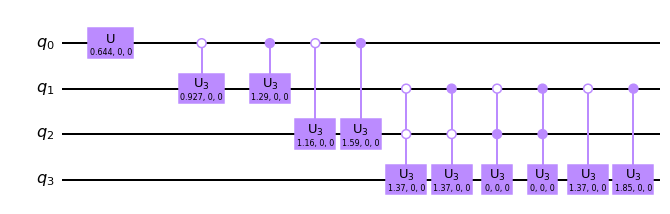

In [12]:
rm, mat = brm(nodes, edges, probsNodes, probsEdges, model2gate=False) 
rm.draw(output='mpl')